STCS Final Project
Cameron Park and Linyue Fan

In [1]:
# Here are some important packages we used
import numpy as np
import pandas as pd
from scipy.io import mmread
from scipy import stats
from collections import OrderedDict
from sklearn.cluster import KMeans
# Plotting imports
import matplotlib
import matplotlib.pyplot as plt
import time
import math
# import pymc3 as pm
import scanpy as sc
import seaborn as sns
import gensim
# for stackoverflow implementation:
import logging
import re

In [2]:
### processing code from scanpy tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html
# sc.logging.print_versions()
# sc.set_figure_params(facecolor="white", figsize=(8, 8))
# sc.settings.verbosity = 3

In [24]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [25]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 3962


Trying to set attribute `.var` of view, copying.


In [28]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [7]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

... storing 'feature_types' as categorical
... storing 'genome' as categorical


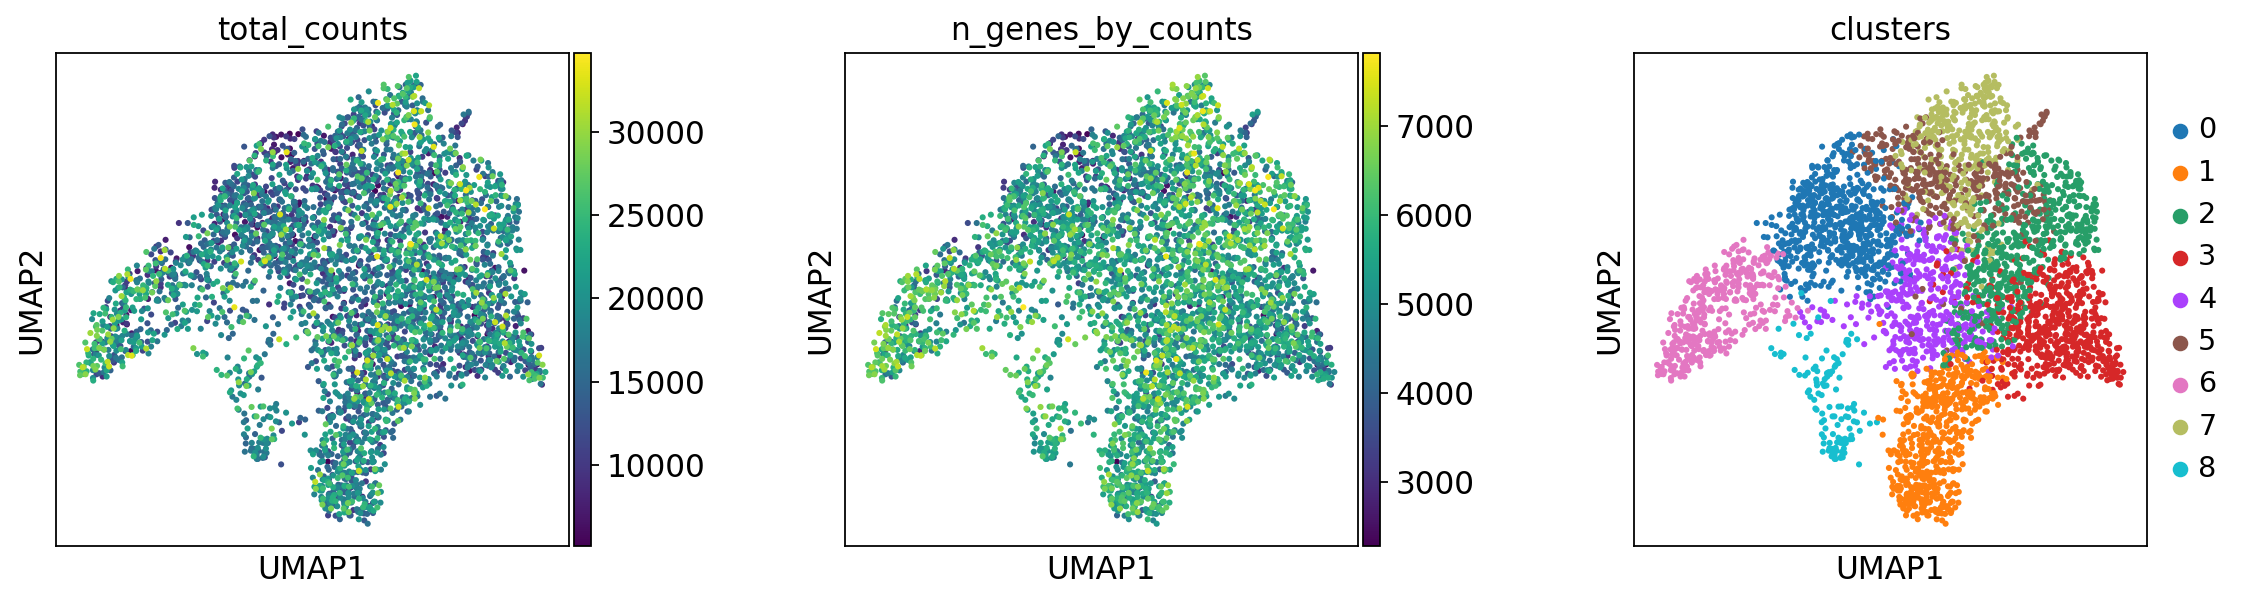

In [9]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

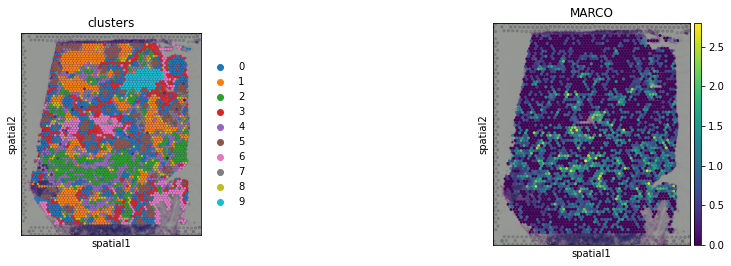

In [130]:
sc.pl.spatial(adata, img_key="hires", color=["clusters","MARCO"], size=1.5)

# LDA

In [13]:
data = adata.to_df()

### FILTERING GENES

In [126]:
#sum of expression PER GENE
ms = data_unnorm.sum(axis=0)
ms_sorted = ms.sort_values(ascending = False)

In [127]:
#getting list of genes with variance <=0.1 
var = data_unnorm.var()
var_sorted = var.sort_values(ascending = False)
low_var_df = var[var_sorted <= 0.1]

In [128]:
#getting list of genes that are expressed in threshold% of all cells
threshold = 0.5
data_binary = pd.DataFrame(data_unnorm)
data_binary = np.sign(data_binary)
binary = pd.DataFrame(data_binary)
ms = binary.sum(axis=0).div(data_unnorm.shape[0])
#all genes expressed in >threshold% of cells
high_counts = ms[ms>threshold]

In [129]:
#removing genes expressed in almost all cells, genes that are evenly expressed across all cells, and known housekeeping genes
low_var = low_var_df.index.to_numpy()
genes_from_high_counts = high_counts.index.to_numpy()
# genelist from: https://www.genomics-online.com/resources/16/5049/housekeeping-genes/
known_housekeeping = ['RRN18S', 'ACTB', 'GAPDH', 'PGK1','PPIA','RPL13A','RPLP0',
                      'ARBP','B2M','YWHAZ', 'SDHA', 'TFRC','GUSB','HMBS', 'HPRT1','TBP']

remove_genes = list(low_var) + list(genes_from_high_counts) + list(known_housekeeping)
remove_array = np.unique(np.array(remove_genes))

for test_gene in remove_array:
    if test_gene in data_unnorm.columns:
        data_unnorm = data_unnorm.drop(columns = test_gene)
        if test_gene in data_unnorm.columns:
            print("gene, ", test_gene,", not dropped")



In [18]:
data.to_pickle("./data_filtered_genes_50exp.pkl")

### Old sklearn implementation

In [2]:
#data = pd.read_pickle("./data_filtered_genes.pkl") #this is just filtered with 95% threshold
data = pd.read_pickle("./data_filtered_genes_50exp.pkl") #filtered with 50% threshold

In [20]:
# in_data = data[0:3566]
# held_out = data[3566:]

In [23]:
# from sklearn.decomposition import LatentDirichletAllocation
# lda = LatentDirichletAllocation(n_components=10, evaluate_every=10)
# factorized = lda.fit_transform(in_data)

In [24]:
# factorized=pd.DataFrame(factorized)
# components=lda.components_
# sort = np.argsort(components)

In [25]:
#three different ways of evaluating sklearn lda?
#lda.bound_

4538.6033937555085

In [52]:
#lda.score(held_out)

-4248812.468847508

In [27]:
#lda.perplexity(held_out)

6023.866768207879

In [76]:
# genelist2=list(data)
# #sorry i write the most inelegant loops
# for i in range(sort.shape[0]):
#     temp=[]
#     for j in range(20):
#         temp.append(genelist2[sort[i][j]])
#     if i==0: 
#         genes=np.asarray([temp])
#     else: 
#         genes=np.append(genes,[temp],axis=0)

# genes=pd.DataFrame(genes)

In [77]:
# #get the genes that are duplicated more than dup_value times
# dup_value = 3 #chose 3 bc 1 seemed really low
# a,c = np.unique(np.array(genes), return_counts=True)
# gene_array = np.array(genes)
# dup = a[c > dup_value]

In [78]:
# #create dictioary with each component as key and values are the genes that belong in that component (of the top 20 genes)
# gene_array = np.array(genes)
# comp_dict = OrderedDict()
# for i in range(len(gene_array)):
#     component = gene_array[i]
#     array = []
#     for k in range(len(component)):
#         if component[k] not in dup:
#             array.append(str(component[k]))
#     comp_dict[i] = array
            

In [85]:
# np.save('comp_dict_50threshold.npy', comp_dict) 
#test_dict = np.load('comp_dict_50threshold.npy',allow_pickle='TRUE').item()

In [82]:
## CODE FOR HOW TO SAVE AND LOAD DICTIONARIES 
# # Save
# dictionary = {'hello':'world'}
# np.save('my_file.npy', dictionary) 

# # Load
# read_dictionary = np.load('my_file.npy',allow_pickle='TRUE').item()
# print(read_dictionary['hello']) # displays "world"

# Alternative gensim implementation

In [11]:
#create dictionary that tells you how many spots are in each cluster
clusters=adata.obs["clusters"]
cluster_counts={}
for i in clusters:
    if i not in cluster_counts:
        cluster_counts[i]=1
    else:
        cluster_counts[i]=cluster_counts[i]+1
#normalize to get distribution of spots per cluster => use this for alpha prior
types_prior10=list(cluster_counts.values())/np.sum(list(cluster_counts.values()))

In [3]:
data_np=np.asarray(data)

In [4]:
#reformat data into "corpus" for gensim-each entry is a tuple of form (gene index, count)
data_ids=[]
for i in range(data_np.shape[0]):
    temp=[]
    for j in range(data_np.shape[1]):
        temp.append((j,int(data_np[i][j]*1000))) #here we multiply by 1000 and type cast to int to simulate BOW representation

    data_ids.append(temp)

#create id2word dict, maps index to gene name
id_dict={}
geneids=list(data)
for i in range(data_np.shape[1]):
    id_dict[i]=geneids[i]

In [5]:
sample = np.asarray(data_ids)

In [6]:
in_sample = sample[0:3566]
out_sample = sample[3566:]

In [13]:
in_sample.shape

(3566, 4490, 2)

In [223]:
#"Get the topics with the highest coherence score the coherence for each topic."
#lda_model.top_topics(corpus=data_ids2)

In [51]:
#"Estimate the variational bound of documents from the corpus as E_q[log p(corpus)] - E_q[log q(corpus)]."
#lda_model.bound(corpus=data_ids)

-41519571.4485834

In [183]:
#generate proportions matrix for all the spots
proportions=[]
for i in range(data_ids.shape[0]):
    proportions.append(np.asarray(lda_model.get_document_topics(data_ids[i], minimum_probability=None, minimum_phi_value=None, per_word_topics=False))[:,1])

In [18]:
#our implementation of cellAssign-takes in a proportions vector and assigns each element according to highest proportion
#unassigned spots are -1, defined as having a maximum proportion lower than threshold
#to get proportions without assignments, just set threshold = 0
def assign(props,thresh):
    assignments=[]
    for i in range(len(props)):
        maxx=np.argmax(props[i])
        if props[i][maxx]<thresh:
            assignments.append(str(-1))
        else:
            assignments.append(str(maxx))
    return assignments

In [56]:
#plot according to cluster assignments and a threshold of 0.2 (i merged the code blocks and lost the graph, oops)
assignments=assign(proportions,0.2)

adata.obs["assignments"]=assignments

sc.pl.spatial(adata, img_key="hires", color=["clusters","assignments"], size=1.5)

NameError: name 'assign' is not defined

Choosing best K

In [140]:
perplexities=[]
bounds=[]
#calculate the perplexity for the model when k is between 4 and 20 (excluding every other)
for k in range(4,21):
    if k%2==0:
        lda_model = gensim.models.LdaMulticore(corpus=in_sample2,
                                       id2word=id_dict,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
        perplex=lda_model.log_perplexity(out_sample2)
        bound=lda_model.bound(in_sample2)
        print(perplex,bound)
        perplexities.append(perplex)
        bounds.append(bound)

-8.729707559267448 -78479153840.30263
-8.728484253921184 -78463918289.56007
-8.726437990728899 -78439286659.51698
-8.727081430928072 -78445629145.16042
-8.72510339355896 -78421468733.58078
-8.724900510169462 -78417212878.73178
-8.72501052000545 -78417292124.36926
-8.72461963443163 -78412105321.26059
-8.724343028768992 -78407401431.84639


Text(0, 0.5, 'Log Perplexity')

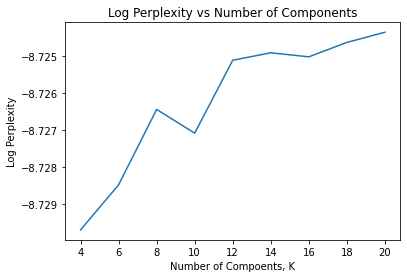

In [143]:
x=[4,6,8,10,12,14,16,18,20]
plt.plot(x, perplexities)
plt.title("Log Perplexity vs Number of Components")
plt.xlabel("Number of Compoents, K")
plt.ylabel("Log Perplexity")

Text(0, 0.5, 'Bound')

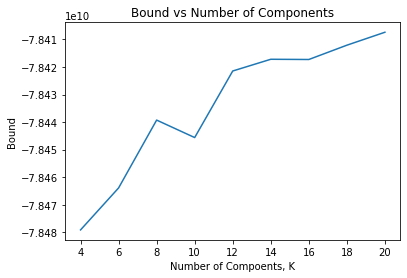

In [144]:
x=[4,6,8,10,12,14,16,18,20]
plt.plot(x, bounds)
plt.title("Bound vs Number of Components")
plt.xlabel("Number of Compoents, K")
plt.ylabel("Bound")

Text(0, 0.5, 'Log Perplexity')

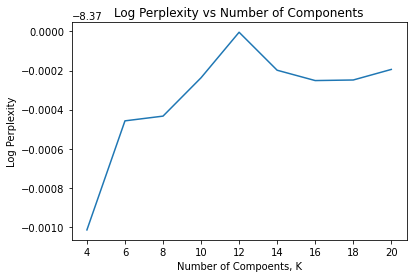

In [115]:
x=[4,6,8,10,12,14,16,18,20]
plt.plot(x, perplexities)
plt.title("Log Perplexity vs Number of Components")
plt.xlabel("Number of Compoents, K")
plt.ylabel("Log Perplexity")

Re-run model with tuned parameters

In [7]:
#since scanpy.leiden only detects 10 clusters, we use kmeans to obtain topic priors for 12 clusters
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=12, random_state=0).fit_predict(data_np)

In [8]:
clusters=kmeans
cluster_counts={}
for i in clusters:
    if i not in cluster_counts:
        cluster_counts[i]=1
    else:
        cluster_counts[i]=cluster_counts[i]+1
#normalize to get distribution of spots per cluster => use this for alpha prior
types_prior=list(cluster_counts.values())/np.sum(list(cluster_counts.values()))

In [22]:
# lda_model = gensim.models.LdaMulticore(corpus=in_sample,
#                                        id2word=id_dict,
#                                        num_topics=12, 
#                                        alpha=types_prior,
#                                        random_state=100,
#                                        chunksize=100,
#                                        passes=10,
#                                        per_word_topics=True)

In [12]:
#print in order of most significant topics/most significant words
#FOR PASS = 20
lda_model.print_topics()

[(0,
  '0.001*"RGS13" + 0.001*"MYBL1" + 0.001*"FCAMR" + 0.001*"HOPX" + 0.001*"GCSAM" + 0.001*"SERPINA9" + 0.001*"GCHFR" + 0.001*"BCL7A" + 0.001*"CDCA7" + 0.001*"EAF2"'),
 (1,
  '0.001*"MARCO" + 0.001*"FMOD" + 0.001*"MCAM" + 0.001*"TFPI" + 0.001*"CCL20" + 0.001*"CHI3L1" + 0.001*"ACKR3" + 0.001*"CAVIN1" + 0.001*"FN1" + 0.001*"C1QTNF1"'),
 (2,
  '0.001*"RGS13" + 0.001*"CDK1" + 0.001*"TK1" + 0.001*"CDCA7" + 0.001*"WEE1" + 0.001*"GCHFR" + 0.001*"BIK" + 0.001*"TPX2" + 0.001*"NDC1" + 0.001*"BCL2L12"'),
 (3,
  '0.001*"GABPB1-AS1" + 0.001*"ZNF652" + 0.001*"CRIP3" + 0.001*"CDK5RAP2" + 0.001*"ZNF318" + 0.001*"AMPD3" + 0.001*"LINC01480" + 0.001*"GAPT" + 0.001*"DMXL1" + 0.001*"NUP205"'),
 (4,
  '0.001*"SIGLEC1" + 0.001*"GPX3" + 0.001*"SLCO2A1" + 0.001*"SDC1" + 0.001*"PDK1" + 0.001*"PSEN1" + 0.001*"CLDN15" + 0.001*"CARD19" + 0.001*"ERN1" + 0.001*"TSPAN7"'),
 (5,
  '0.001*"CAMK4" + 0.001*"SIRPG" + 0.001*"APBA2" + 0.001*"BICDL1" + 0.001*"DUSP16" + 0.001*"MAN1C1" + 0.001*"BCL9L" + 0.001*"TC2N" + 0.001*

In [11]:
#print in order of most significant topics/most significant words
#FOR PASS = 25
lda_model.print_topics()

[(0,
  '0.001*"RGS13" + 0.001*"MYBL1" + 0.001*"FCAMR" + 0.001*"HOPX" + 0.001*"GCSAM" + 0.001*"SERPINA9" + 0.001*"GCHFR" + 0.001*"BCL7A" + 0.001*"GMDS" + 0.001*"CDCA7"'),
 (1,
  '0.001*"FMOD" + 0.001*"MARCO" + 0.001*"MCAM" + 0.001*"TFPI" + 0.001*"CAVIN1" + 0.001*"CCL20" + 0.001*"CHI3L1" + 0.001*"FN1" + 0.001*"C1QTNF1" + 0.001*"ACKR3"'),
 (2,
  '0.001*"RGS13" + 0.001*"CDK1" + 0.001*"TK1" + 0.001*"CDCA7" + 0.001*"WEE1" + 0.001*"NDC1" + 0.001*"BCL2L12" + 0.001*"TPX2" + 0.001*"BIK" + 0.001*"GCHFR"'),
 (3,
  '0.001*"GABPB1-AS1" + 0.001*"CRIP3" + 0.001*"ZNF652" + 0.001*"LINC01480" + 0.001*"CDK5RAP2" + 0.001*"AMPD3" + 0.001*"ZNF318" + 0.001*"GAPT" + 0.001*"DMXL1" + 0.001*"NUP205"'),
 (4,
  '0.001*"SLCO2A1" + 0.001*"GPX3" + 0.001*"SIGLEC1" + 0.001*"SDC1" + 0.001*"PDK1" + 0.001*"PSEN1" + 0.001*"CLDN15" + 0.001*"TSPAN7" + 0.001*"CARD19" + 0.001*"ERN1"'),
 (5,
  '0.001*"CAMK4" + 0.001*"SIRPG" + 0.001*"APBA2" + 0.001*"BICDL1" + 0.001*"DUSP16" + 0.001*"MAN1C1" + 0.001*"TC2N" + 0.001*"BCL9L" + 0.001*

In [11]:
#print in order of most significant topics/most significant words
#FOR PASS = 35
lda_model.print_topics()

[(0,
  '0.002*"RGS13" + 0.001*"MYBL1" + 0.001*"FCAMR" + 0.001*"HOPX" + 0.001*"SERPINA9" + 0.001*"GCSAM" + 0.001*"GCHFR" + 0.001*"GMDS" + 0.001*"BCL7A" + 0.001*"CDCA7"'),
 (1,
  '0.001*"FMOD" + 0.001*"MCAM" + 0.001*"CAVIN1" + 0.001*"TFPI" + 0.001*"TCIM" + 0.001*"MARCO" + 0.001*"FN1" + 0.001*"ID1" + 0.001*"BGN" + 0.001*"C1QTNF1"'),
 (2,
  '0.001*"RGS13" + 0.001*"CDK1" + 0.001*"TK1" + 0.001*"CDCA7" + 0.001*"WEE1" + 0.001*"NDC1" + 0.001*"BCL2L12" + 0.001*"TPX2" + 0.001*"BIK" + 0.001*"GCHFR"'),
 (3,
  '0.001*"GABPB1-AS1" + 0.001*"CRIP3" + 0.001*"ZNF652" + 0.001*"LINC01480" + 0.001*"CDK5RAP2" + 0.001*"AMPD3" + 0.001*"ZNF318" + 0.001*"GAPT" + 0.001*"SLC25A32" + 0.001*"DMXL1"'),
 (4,
  '0.001*"SLCO2A1" + 0.001*"GPX3" + 0.001*"SDC1" + 0.001*"PDK1" + 0.001*"CLDN15" + 0.001*"PSEN1" + 0.001*"TSPAN7" + 0.001*"SIGLEC1" + 0.001*"CARD19" + 0.001*"ITGA6"'),
 (5,
  '0.001*"CAMK4" + 0.001*"SIRPG" + 0.001*"APBA2" + 0.001*"BICDL1" + 0.001*"MAN1C1" + 0.001*"DUSP16" + 0.001*"TC2N" + 0.001*"MAL" + 0.001*"IL11

Notes:
Cluster 0: looks like some cancer associated genes?
Cluster 1: MARCO is a macrophage gene
Cluster 8: SIGLEC1 major macrophage marker, IL3 involved in macro signaling?

In [12]:
#generate proportions matrix for all the spots
proportions=[]
for i in range(sample.shape[0]):
    temp=lda_model.get_document_topics(sample[i], minimum_probability=None, minimum_phi_value=None, per_word_topics=False)
    indices=list(np.asarray(temp)[:,0])
    props=np.asarray(temp)[:,1]
    tempp=[]
    #apparently gensim just drops components, so add them back as 0 to keep array shape
    for j in range(12):
        if (j in indices)==True:
            tempp.append(props[indices.index(j)])
        else:
            tempp.append(0)
    #print(proportions[i].shape)
    proportions.append(tempp)

In [67]:
test=[0,1,2,3]
print(test.index(2))

2


In [57]:
np.asarray(lda_model.get_document_topics(in_sample[1953], minimum_probability=None, minimum_phi_value=None, per_word_topics=False))[:,1]

array([0.60639405, 0.02311466, 0.06694894, 0.05582641, 0.015733  ,
       0.02159916, 0.02133627, 0.05204829, 0.02213275, 0.06780987,
       0.01766142, 0.02939521])

In [19]:
#now we use threshold=0 so that we can get full picture of the proportions
assignments=assign(proportions,0)

In [20]:
#look at the amount of mixing happening in each cluster
kmeans_insample=kmeans[0:3566]
per_cluster_proportions=np.zeros((12,12)) #clusters x components

#for each spot, sum the component counts into the cluster it belongs to
for i in range(kmeans_insample.shape[0]):
    category=int(assignments[i])
    #if i==-1:
     #   category=12
    per_cluster_proportions[kmeans_insample[i]][category]+=1

In [21]:
components=["0","1","2","3","4","5","6","7","8","9","10","11"]

Text(0.5, 0.98, 'Kmeans clusters 0-5')

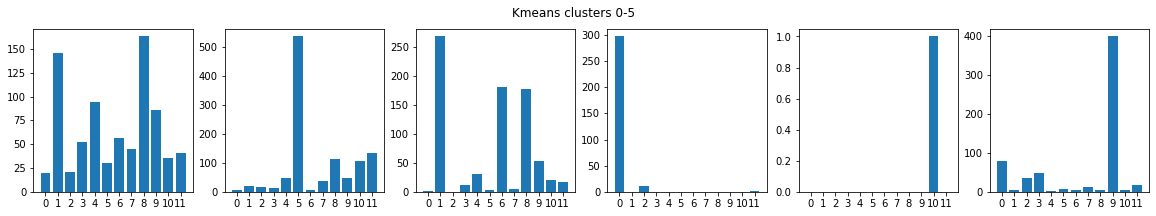

In [22]:
fig, axs = plt.subplots(1, 6, figsize=(20, 3), sharey=False)
axs[0].bar(components,per_cluster_proportions[0])
axs[1].bar(components,per_cluster_proportions[1])
axs[2].bar(components,per_cluster_proportions[2])
axs[3].bar(components,per_cluster_proportions[3])
axs[4].bar(components,per_cluster_proportions[4])
axs[5].bar(components,per_cluster_proportions[5])


fig.suptitle('Kmeans clusters 0-5')

Text(0.5, 0.98, 'Kmeans clusters 6-11')

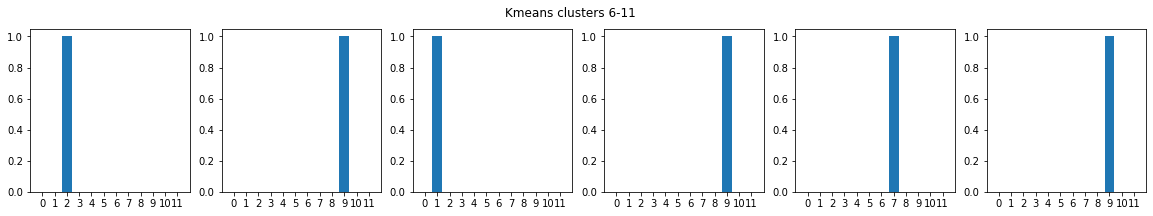

In [23]:
fig, axs = plt.subplots(1, 6,figsize=(20,3),sharey=False)
axs[0].bar(components,per_cluster_proportions[6])
axs[1].bar(components,per_cluster_proportions[7])
axs[2].bar(components,per_cluster_proportions[8])
axs[3].bar(components,per_cluster_proportions[9])
axs[4].bar(components,per_cluster_proportions[10])
axs[5].bar(components,per_cluster_proportions[11])
fig.suptitle("Kmeans clusters 6-11")

In [14]:
kmeans_insample=kmeans[0:3566]
per_cluster_proportions_raw=np.zeros((12,12)) #clusters x components

#for each spot, sum the component counts into the cluster it belongs to
for i in range(kmeans_insample.shape[0]):
    per_cluster_proportions_raw[kmeans_insample[i]]+proportions[i]
    per_cluster_proportions_raw[kmeans_insample[i]]=(per_cluster_proportions_raw[kmeans_insample[i]]+proportions[i])

In [15]:
for i in range(per_cluster_proportions_raw.shape[0]):
    per_cluster_proportions_raw[i]=per_cluster_proportions_raw[i]/np.sum(per_cluster_proportions_raw[i])

Text(0.5, 0.98, 'Kmeans clusters 0-5')

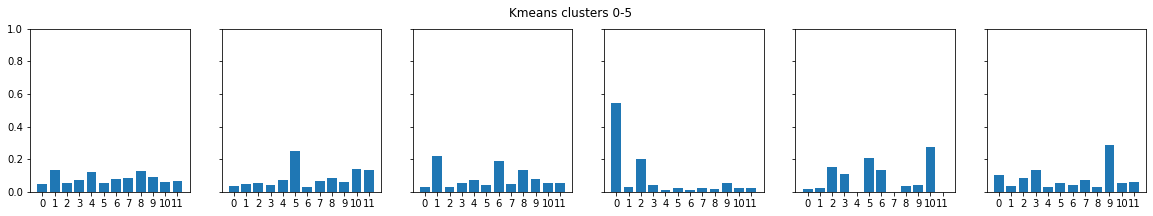

In [16]:
fig, axs = plt.subplots(1, 6, figsize=(20, 3), sharey=True)
axs[0].set_ylim([0,1])
axs[0].bar(components,per_cluster_proportions_raw[0])
axs[1].bar(components,per_cluster_proportions_raw[1])
axs[2].bar(components,per_cluster_proportions_raw[2])
axs[3].bar(components,per_cluster_proportions_raw[3])
axs[4].bar(components,per_cluster_proportions_raw[4])
axs[5].bar(components,per_cluster_proportions_raw[5])


fig.suptitle('Kmeans clusters 0-5')

Text(0.5, 0.98, 'Kmeans clusters 6-11')

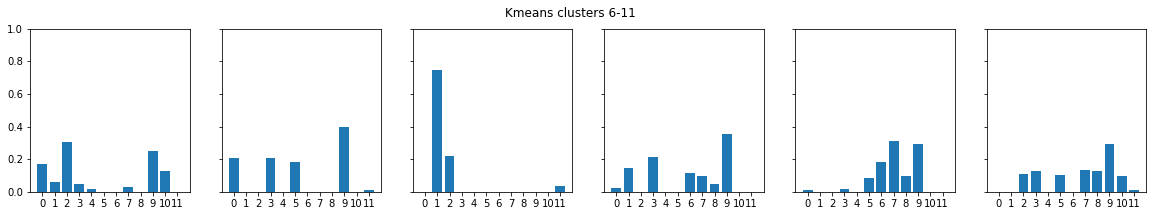

In [17]:
fig, axs = plt.subplots(1, 6,figsize=(20,3),sharey=True)
axs[0].set_ylim([0,1])
axs[0].bar(components,per_cluster_proportions_raw[6])
axs[1].bar(components,per_cluster_proportions_raw[7])
axs[2].bar(components,per_cluster_proportions_raw[8])
axs[3].bar(components,per_cluster_proportions_raw[9])
axs[4].bar(components,per_cluster_proportions_raw[10])
axs[5].bar(components,per_cluster_proportions_raw[11])
fig.suptitle("Kmeans clusters 6-11")

In [26]:
#convert kmeans labels to string for tabular graphing
strkmeans=[]
for i in kmeans:
    strkmeans.append(str(i))

In [27]:
assignments=assign(proportions,0)#0.2)

adata.obs["kmeans"]=strkmeans

#sc.pl.spatial(adata, img_key="hires", color=["clusters"], size=1.5,save=True)

In [28]:
adata.obs.shape

(3962, 16)

... storing 'kmeans' as categorical
... storing 'assignments' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


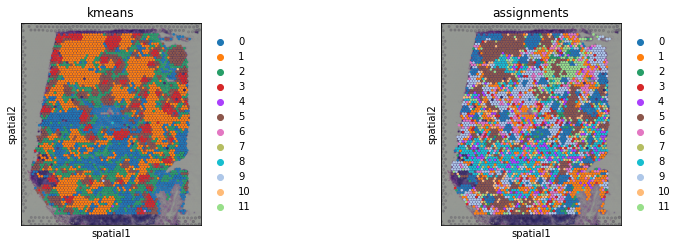

In [29]:
adata.obs["assignments"]=assignments

sc.pl.spatial(adata, img_key="hires", color=["kmeans","assignments"], size=1.5,save=True)

In [163]:
in_sample.shape

-37013429244.656075


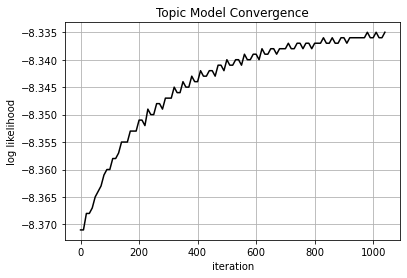

In [10]:
lda_model=lda_elbo(in_sample, id_dict, 12, 10)

In [9]:
import logging
import gensim
import re
def lda_elbo(in_sample,id_dict,num_topics, eval_every):
    #this creates a logging file that I believe saves value at every eval_every
    #code from stack overflow
    logging.basicConfig(filename='gensim.log',
                        filemode='w',
                        format="%(asctime)s:%(levelname)s:%(message)s",
                        level=logging.INFO)
    #run lda model, set eval_every to 10 (if too slow can increase)
    lda_model = gensim.models.LdaMulticore(corpus=in_sample,
                                           id2word=id_dict,
                                           num_topics=num_topics, 
                                           alpha=types_prior,
                                           random_state=100,
                                           chunksize=100,
                                           eval_every=eval_every,
                                           passes=35,
                                           iterations=1000,
                                           per_word_topics=True)
    #calculate the bound to see how it compares to perplexity
    b=lda_model.bound(corpus=in_sample)
    print(b)
    #following code from stack overflow: 
    #https://stackoverflow.com/questions/37570696/how-to-monitor-convergence-of-gensim-lda-model
    p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
    matches = [p.findall(l) for l in open('gensim.log')]
    matches = [m for m in matches if len(m) > 0]
    tuples = [t[0] for t in matches]
    perplexity = [float(t[1]) for t in tuples]
    liklihood = [float(t[0]) for t in tuples]
    iter = list(range(0,len(tuples)*10,10))
    plt.plot(iter,liklihood,c="black")
    plt.ylabel("log likelihood")
    plt.xlabel("iteration")
    plt.title("Topic Model Convergence")
    plt.grid()
    plt.show()
    #save figure to pdf
    k=12
    plt.savefig("convergence_liklihood_" + str(k) +"topics"+ ".pdf")
    plt.close()
    return lda_model

